# Distributed Hyperparameter Tuning using Ray

This tutorial shows and example of using Ray Tune to perform a simple training task.  

The task consists of training a CNN model on the MNIST dataset using PyTorch. As part of this hands-on we will integrate Ray Tune into a PyTorch training workflow, which is fairly straightforward. All we need to do besides building the model using standard PyTorch is to:

1. wrap data loading and training in functions

2. make some network parameters configurable

3. add checkpointing (optional and not covered here)

4. and define the search space for the model tuning

See references for more information.

#### References:

Ray RLLib Documentation: [Ray RLLib Documentation](https://docs.ray.io/en/master/rllib.html)

Ray Tune Documentation: [Ray Tune Documentation](https://docs.ray.io/en/master/tune/index.html)

*This tutorial is adapted from the documentation for Ray version 1.12

In [26]:
import os
import ray
import torch

import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ray.tune.schedulers import ASHAScheduler
from ray import tune

Let's begin by using the standard code for connecting to Ray (identical to what we did in Ray-Lab00)

In [27]:
if ray.is_initialized() == False:
    print("Connecting to Ray cluster...")
    service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
    service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
    ray.init(f"ray://{service_host}:{service_port}")

In [28]:
ray.is_initialized()

True

Next, we define a very basic CNN with a one convolutional, one pooling, and one fully connected layers.

In [29]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


Here things get a bit tricky. Because Ray uses a distributed architecture we can no longer store the training data in our local file system (i.e. in the workspace we are currently using). All Ray cluster nodes must have access to the data in order for Ray to be able to parallelize the execution. 

Luckily, Domino provides [Domion Datasets](https://docs.dominodatalab.com/en/latest/user_guide/0a8d11/domino-datasets/) - a high-performance, versioned, and structured filesystem. This filesystem is a collection of files that are available in user executions (e.g. workspaces and jobs) as a filesystem directory. Every time we start a workspace (with or without an attached cluster) Domino instantiates a local Dataset for the execution, which is available in */domino/datasets/local/\<name_of_your_project\>*. 

Because the name of your project forms part of the absolute dataset path, we can't hard-code it in the notebook. Instead, we'll use an environment variable containing your project name, which Domino conveniently sets for us in each execution.

In [30]:
domino_project = os.environ['DOMINO_PROJECT_NAME']
data_path = os.path.join("/domino/datasets/local", os.environ['DOMINO_PROJECT_NAME'])
print(data_path)

/domino/datasets/local/odsc-test


### Task 1

* Inspect the contents of *data_path*. You can open a new terminal by selecting File -> New -> Terminal in JupyterLab.

Now let's get MNIST into the shared filesystem.

In [31]:
# Download the dataset first
datasets.MNIST(data_path, train=True, download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /domino/datasets/local/odsc-test
    Split: Train

* Inspect *data_path* again. You should now have an MNIST directory created with the raw MNIST subsets (training, test) present.

Next, we set up our training loop. This is implemented in the *train_mist* function.

Notice that *train_mnist* receives a config dictionary with the training hyperparameters. This is identical to how we were performing the training in HyperOpt. Inspect the code below and make sure you understand what the training loop is doing.

In [32]:
def train_mnist(config):
    
    # Load the data into a PyTorch tensor and normalise it
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])
    
    # Load the training set
    train_loader = DataLoader(
        datasets.MNIST(data_path, train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    
    # Load the test set
    test_loader = DataLoader(
        datasets.MNIST(data_path, train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    # GPUs available?
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create an instance of the CNN model
    model = ConvNet()
    model.to(device)

    # We use a fixed optim iser - SGD
    # Notice that we get the learning rate and momentum from the config variable
    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    
    # Run 10 training iterations
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")


You noticed that the training loop calls two helper functions - *train* and *test* to update the model parameters and to report accuracy back to Tune. Here is their implementation.

Notice, that we are again using a relatively small sample of the MNIST data, but feel free to tweak this if you'd like your training to run quicker or slower.

In [33]:
# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 1024
TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

### Task 2

Time to set up our search space.

Tune provides a number of functions for sampling ranges in the search space. Some of the widely used sampling routines are:

* *tune.uniform(a,b)* - Uniformly sample a float between a and b
* *tune.randn(mu, std)* - Sample from a Gaussian defined by mean and standard deviation
* *tune.sample_from(lambda x)* - Samples from a custom defined random function
* *tune.grid_search([a,b,c])* - Performs a grid search over [a,b,c]
* *tune.randint(a,b)* - Samples a random integer from [a,b]
* *tune.choice([a,b,c])* - Sample uniformly from the list of values [a,b,c]

For a comprehensive description of the random distributions API check [Ray Tune](https://docs.ray.io/en/releases-1.12.0/tune/api_docs/search_space.html)'s documentation.

Now let's define a *search_space* dictionary with two hyperparameters --- learning rate and momentum.

In [34]:
search_space = {
    "lr": tune.uniform(0.001, 0.1),
    "momentum": tune.choice([0.1, 0.2, 0.5, 0.8, 0.9])
}

Next, we can run a single experiment to validate that our training loop/functions and hyperparameter space are set correctly.

Ray Tune provides a function *tune.run* that executes experiments. Some of the key arguments of the function are:

* *run_or_experiment* - training loop function (*train_mnist* in our case)
* *config* - hyperparameter space. a sample of this dictionary will be passed to the training loop with each iteration
* *resources_per_trial* - machine resources to allocate per trial, e.g. {"cpu": 64, "gpu": 8}
* *checkpoint_freq* - how many training iterations between checkpoints
* *scheduler* - TrialScheduler object for executing the experiment. For example, FIFO (default), MedianStopping, AsyncHyperBand, HyperBand etc.
* *num_samples* – Number of times to sample from the hyperparameter space. 

*tune.run* returns an *ExperimentAnalysis* instance for analyzing the results from a Tune experiment.

Make a call to *tune.run* and execute 1 experiment using the current setup. Capture the results in a variable caled *analysis*.

In [35]:
analysis = tune.run(run_or_experiment = train_mnist, config = search_space, num_samples = 1)

(run pid=206) 2023-05-09 11:59:08,706	INFO trial_runner.py:803 -- starting train_mnist_93418_00000


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 11:59:11 (running for 00:00:03.42)
(run pid=206) Memory usage on this node: 2.8/30.6 GiB
(run pid=206) Using FIFO scheduling algorithm.
(run pid=206) Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_11-59-07
(run pid=206) Number of trials: 1/1 (1 RUNNING)
(run pid=206) +-------------------------+----------+------------------+-----------+------------+
(run pid=206) | Trial name              | status   | loc              |        lr |   momentum |
(run pid=206) |-------------------------+----------+------------------+-----------+------------|
(run pid=206) | train_mnist_93418_00000 | RUNNING  | 10.0.68.175:3875 | 0.0938573 |        0.5 |
(run pid=206) +-------------------------+----------+------------------+-----------+------------+
(run pid=206) 
(run pid=206) 
(run pid=206) Result for train_mnist_93418_00000:
(run pi

Let's look at the change in accuracy as traing progresses. We can get this information from the *analysis* object. We'll implement the plotting functionallity in a function as we'll need it later.

(run pid=206) 2023-05-09 11:59:14,226	INFO tune.py:701 -- Total run time: 6.61 seconds (6.49 seconds for the tuning loop).


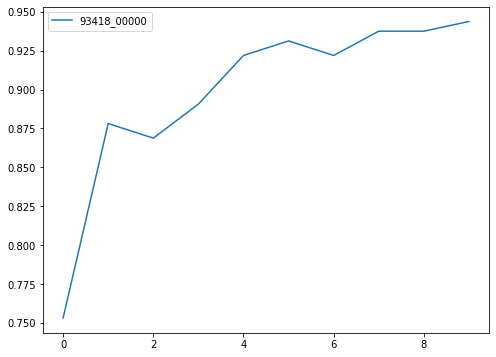

In [36]:
def plot_results(analysis, figsize=(8,6)):

    plt.figure(figsize=figsize)

    dfs = analysis.trial_dataframes

    # Plot by epoch
    ax = None  # This plots everything on the same plot

    trial_ids = analysis.results.keys()
    for l, d in zip(trial_ids, dfs.values()):
        ax = d.mean_accuracy.plot(ax=ax, legend=True, label=l)
        
plot_results(analysis)

The legend in the plot above provides the experiment id. We can see how the accuracy changes over the 10 epochs (remember the *i* loop in *train_mnist*)

Now let's call *tune.run* again, but this time run 10 experiments. Note that Ray Tune first generates the various lr/momentum combinations that it will try, and then it executes the experiments in pairs (because Ray is currently limited to 2 single-CPU nodes).

In [37]:
analysis = tune.run(run_or_experiment = train_mnist, config = search_space, num_samples = 10)

(run pid=206) 2023-05-09 11:59:15,442	INFO trial_runner.py:803 -- starting train_mnist_974df_00000


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 11:59:17 (running for 00:00:03.33)
(run pid=206) Memory usage on this node: 2.8/30.6 GiB
(run pid=206) Using FIFO scheduling algorithm.
(run pid=206) Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_11-59-14
(run pid=206) Number of trials: 10/10 (9 PENDING, 1 RUNNING)
(run pid=206) +-------------------------+----------+------------------+------------+------------+
(run pid=206) | Trial name              | status   | loc              |         lr |   momentum |
(run pid=206) |-------------------------+----------+------------------+------------+------------|
(run pid=206) | train_mnist_974df_00000 | RUNNING  | 10.0.68.175:3979 | 0.0483216  |        0.5 |
(run pid=206) | train_mnist_974df_00001 | PENDING  |                  | 0.0516219  |        0.5 |
(run pid=206) | train_mnist_974df_00002 | PENDING  |                 

(run pid=206) 2023-05-09 11:59:17,752	INFO trial_runner.py:803 -- starting train_mnist_974df_00001


(run pid=206) Result for train_mnist_974df_00000:
(run pid=206)   date: 2023-05-09_11-59-18
(run pid=206)   done: false
(run pid=206)   experiment_id: a813c0a268944f769cf0161e669ca433
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.64375
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 3979
(run pid=206)   time_since_restore: 0.42058634757995605
(run pid=206)   time_this_iter_s: 0.42058634757995605
(run pid=206)   time_total_s: 0.42058634757995605
(run pid=206)   timestamp: 1683658758
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: 974df_00000
(run pid=206)   warmup_time: 0.002178668975830078
(run pid=206)   
(run pid=206) Result for train_mnist_974df_00001:
(run pid=206)   date: 2023-05-09_11-59-20
(run pid=206)   done: false
(run pid=206)   experiment_id: 54072ab89d834ef48987a78260d3381c
(run pid=206)   hostname: ray-645a96

(run pid=206) 2023-05-09 11:59:22,123	INFO trial_runner.py:803 -- starting train_mnist_974df_00002


(run pid=206) Result for train_mnist_974df_00001:
(run pid=206)   date: 2023-05-09_11-59-23
(run pid=206)   done: true
(run pid=206)   experiment_id: 54072ab89d834ef48987a78260d3381c
(run pid=206)   experiment_tag: 1_lr=0.051622,momentum=0.5
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-worker-0
(run pid=206)   iterations_since_restore: 10
(run pid=206)   mean_accuracy: 0.9
(run pid=206)   node_ip: 10.0.73.213
(run pid=206)   pid: 1396
(run pid=206)   time_since_restore: 3.188088893890381
(run pid=206)   time_this_iter_s: 0.30608439445495605
(run pid=206)   time_total_s: 3.188088893890381
(run pid=206)   timestamp: 1683658763
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 10
(run pid=206)   trial_id: 974df_00001
(run pid=206)   warmup_time: 0.0025484561920166016
(run pid=206)   
(run pid=206) Result for train_mnist_974df_00002:
(run pid=206)   date: 2023-05-09_11-59-24
(run pid=206)   done: false
(run pid=206)   experiment_id: f8fcf512a91e47

(run pid=206) 2023-05-09 11:59:25,214	INFO trial_runner.py:803 -- starting train_mnist_974df_00003


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 11:59:27 (running for 00:00:13.01)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using FIFO scheduling algorithm.
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_11-59-14
(run pid=206) Number of trials: 10/10 (6 PENDING, 2 RUNNING, 2 TERMINATED)
(run pid=206) +-------------------------+------------+------------------+------------+------------+----------+--------+------------------+
(run pid=206) | Trial name              | status     | loc              |         lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |-------------------------+------------+------------------+------------+------------+----------+--------+------------------|
(run pid=206) | train_mnist_974df_00002 | RUNNING    | 10.0.68.175:4081 | 0.0887231  |        0.5 | 0.91875  |      4 |         

(run pid=206) 2023-05-09 11:59:30,132	INFO trial_runner.py:803 -- starting train_mnist_974df_00004


(run pid=206) Result for train_mnist_974df_00003:
(run pid=206)   date: 2023-05-09_11-59-30
(run pid=206)   done: true
(run pid=206)   experiment_id: e89b3f5414864dd6b95bc1f801c9b2e4
(run pid=206)   experiment_tag: 3_lr=0.055564,momentum=0.2
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-worker-0
(run pid=206)   iterations_since_restore: 10
(run pid=206)   mean_accuracy: 0.85625
(run pid=206)   node_ip: 10.0.73.213
(run pid=206)   pid: 1452
(run pid=206)   time_since_restore: 3.270338535308838
(run pid=206)   time_this_iter_s: 0.32051610946655273
(run pid=206)   time_total_s: 3.270338535308838
(run pid=206)   timestamp: 1683658770
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 10
(run pid=206)   trial_id: 974df_00003
(run pid=206)   warmup_time: 0.0025916099548339844
(run pid=206)   


(run pid=206) 2023-05-09 11:59:32,195	INFO trial_runner.py:803 -- starting train_mnist_974df_00005


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 11:59:34 (running for 00:00:20.04)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using FIFO scheduling algorithm.
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_11-59-14
(run pid=206) Number of trials: 10/10 (4 PENDING, 2 RUNNING, 4 TERMINATED)
(run pid=206) +-------------------------+------------+------------------+------------+------------+----------+--------+------------------+
(run pid=206) | Trial name              | status     | loc              |         lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |-------------------------+------------+------------------+------------+------------+----------+--------+------------------|
(run pid=206) | train_mnist_974df_00004 | RUNNING    | 10.0.68.175:4189 | 0.0412747  |        0.9 |          |        |         

(run pid=206) 2023-05-09 11:59:38,150	INFO trial_runner.py:803 -- starting train_mnist_974df_00006
(run pid=206) 2023-05-09 11:59:40,245	INFO trial_runner.py:803 -- starting train_mnist_974df_00007


(run pid=206) Result for train_mnist_974df_00006:
(run pid=206)   date: 2023-05-09_11-59-40
(run pid=206)   done: false
(run pid=206)   experiment_id: 63590579b20443f0a5277676c228d79a
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.775
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 4331
(run pid=206)   time_since_restore: 0.385831356048584
(run pid=206)   time_this_iter_s: 0.385831356048584
(run pid=206)   time_total_s: 0.385831356048584
(run pid=206)   timestamp: 1683658780
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: 974df_00006
(run pid=206)   warmup_time: 0.002171754837036133
(run pid=206)   
(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 11:59:42 (running for 00:00:28.13)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using FIFO scheduling algorithm.
(run pid=206) Resources re

(run pid=206) 2023-05-09 11:59:45,131	INFO trial_runner.py:803 -- starting train_mnist_974df_00008


(run pid=206) Result for train_mnist_974df_00007:
(run pid=206)   date: 2023-05-09_11-59-45
(run pid=206)   done: true
(run pid=206)   experiment_id: a6d347b525734d16a4e09d1192a3f4c0
(run pid=206)   experiment_tag: 7_lr=0.092306,momentum=0.1
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-worker-0
(run pid=206)   iterations_since_restore: 10
(run pid=206)   mean_accuracy: 0.95
(run pid=206)   node_ip: 10.0.73.213
(run pid=206)   pid: 1564
(run pid=206)   time_since_restore: 3.111172914505005
(run pid=206)   time_this_iter_s: 0.30708980560302734
(run pid=206)   time_total_s: 3.111172914505005
(run pid=206)   timestamp: 1683658785
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 10
(run pid=206)   trial_id: 974df_00007
(run pid=206)   warmup_time: 0.002552032470703125
(run pid=206)   


(run pid=206) 2023-05-09 11:59:47,344	INFO trial_runner.py:803 -- starting train_mnist_974df_00009


(run pid=206) Result for train_mnist_974df_00008:
(run pid=206)   date: 2023-05-09_11-59-47
(run pid=206)   done: false
(run pid=206)   experiment_id: 71dd9bf32d9a4f7a89d3781d4839d4f8
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.3125
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 4466
(run pid=206)   time_since_restore: 0.3930070400238037
(run pid=206)   time_this_iter_s: 0.3930070400238037
(run pid=206)   time_total_s: 0.3930070400238037
(run pid=206)   timestamp: 1683658787
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: 974df_00008
(run pid=206)   warmup_time: 0.002044200897216797
(run pid=206)   
(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 11:59:49 (running for 00:00:35.17)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using FIFO scheduling algorithm.
(run pid=206) Resource

(run pid=206) 2023-05-09 11:59:52,893	INFO tune.py:701 -- Total run time: 38.49 seconds (38.36 seconds for the tuning loop).


Let's plot the results.

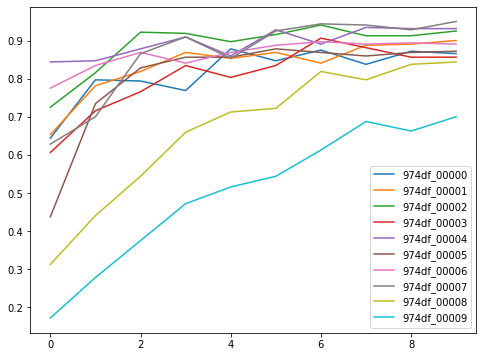

In [38]:
plot_results(analysis)

*ExperimentAnalysis* provides various methods for processing the experiment data. For example, *get_best_config* can show the configuration that provided the best result according to a specified criterion. In our case we care about the maximal accuracy so the call should look like this:

In [39]:
analysis.get_best_config("mean_accuracy", "max")

{'lr': 0.09230608289304196, 'momentum': 0.1}

We could also pull the results data into a data frame for further analysis:

In [40]:
dfs = analysis.trial_dataframes

And also look at detailed "per epoch" data for individual experiments.

In [41]:
list(dfs.values())[0]

,mean_accuracy,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time
0,0.643750,0.420586,False,NaN,NaN,1,974df_00000,a813c0a268944f769cf0161e669ca433,2023-05-09_11-59-18,1683658758,0.420586,3979,ray-645a96d5935490051989b8cf-ray-head-0,10.0.68.175,0.420586,0,1,0.002179
1,0.796875,0.298222,False,NaN,NaN,2,974df_00000,a813c0a268944f769cf0161e669ca433,2023-05-09_11-59-18,1683658758,0.718809,3979,ray-645a96d5935490051989b8cf-ray-head-0,10.0.68.175,0.718809,0,2,0.002179
2,0.793750,0.387945,False,NaN,NaN,3,974df_00000,a813c0a268944f769cf0161e669ca433,2023-05-09_11-59-18,1683658758,1.106754,3979,ray-645a96d5935490051989b8cf-ray-head-0,10.0.68.175,1.106754,0,3,0.002179
3,0.768750,0.285810,False,NaN,NaN,4,974df_00000,a813c0a268944f769cf0161e669ca433,2023-05-09_11-59-19,1683658759,1.392564,3979,ray-645a96d5935490051989b8cf-ray-head-0,10.0.68.175,1.392564,0,4,0.002179
4,0.878125,0.294212,False,NaN,NaN,5,974df_00000,a813c0a268944f769cf0161e669ca433,2023-05-09_11-59-19,1683658759,1.686776,3979,ray-645a96d5935490051989b8cf-ray-head-0,10.0.68.175,1.686776,0,5,0.002179
5,0.846875,0.276836,False,NaN,NaN,6,974df_00000,a813c0a268944f769cf0161e669ca433,2023-05-09_11-59-19,1683658759,1.963612,3979,ray-645a96d5935490051989b8cf-ray-head-0,10.0.68.175,1.963612,0,6,0.002179
6,0.875000,0.273128,False,NaN,NaN,7,974df_00000,a813c0a268944f769cf0161e669ca433,2023-05-09_11-59-19,1683658759,2.236740,3979,ray-645a96d5935490051989b8cf-ray-head-0,10.0.68.175,2.236740,0,7,0.002179
7,0.837500,0.281255,False,NaN,NaN,8,974df_00000,a813c0a268944f769cf0161e669ca433,2023-05-09_11-59-20,1683658760,2.517995,3979,ray-645a96d5935490051989b8cf-ray-head-0,10.0.68.175,2.517995,0,8,0.002179
8,0.871875,0.292902,False,NaN,NaN,9,974df_00000,a813c0a268944f769cf0161e669ca433,2023-05-09_11-59-20,1683658760,2.810897,3979,ray-645a96d5935490051989b8cf-ray-head-0,10.0.68.175,2.810897,0,9,0.002179
9,0.865625,0.301181,False,NaN,NaN,10,974df_00000,a813c0a268944f769cf0161e669ca433,2023-05-09_11-59-20,1683658760,3.112079,3979,ray-645a96d5935490051989b8cf-ray-head-0,10.0.68.175,3.112079,0,10,0.002179


## Early stopping

One issue with search that we've just conducted is that it keeps indiscriminately training all possible hyperparameter combinations for the fixed number of training iterations (epochs). This may not be the most optimal strategy, especially if we can identify that certain combinations are less promising. One obvious idea is to introduce some kind of an early stopping criterion, which terminates hyperparameter combinations that perform badly and focuses on more promising experiments. Ray Tune provides such functionallity in its ASHA (Asynchronous Successive HAlving) scheduler.

The intuition behind the successive halving algorithm is the following. 

* We begin with all candidate configurations in a base rung.
* Uniformly allocate a budget to a set of candidate hyperparameter configurations in a given rung.
* Evaluate the performance of all candidate configurations.
* Promote the top half of candidate configurations to the next rung.
* Double the budget per configuration for the next rung and repeat until one configurations remains.  

For more details on how ASHA works, please see [Massively Parallel Hyperparameter Optimization](https://blog.ml.cmu.edu/2018/12/12/massively-parallel-hyperparameter-optimization/)

Let's see how we can do the hyperparameter space exploration using ASHA. First, we create the scheduler and set the objective.

In [42]:
asha = ASHAScheduler(metric="mean_accuracy", mode="max")

Now let's call *tune.run*. We can also crank up the number of samples to 20 as we'll be abandonig some of them anyway.
Add the relevant values to the *tune.run* call and keep an eye on the *iter* column in the trials table that Ray Tune periodically prints.

In [43]:
analysis = tune.run(
    run_or_experiment = train_mnist, 
    config = search_space, 
    num_samples = 20,
    scheduler = asha
)

(run pid=206) 2023-05-09 11:59:54,348	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00000


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 11:59:56 (running for 00:00:03.34)
(run pid=206) Memory usage on this node: 2.8/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=0
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
(run pid=206) Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_11-59-53
(run pid=206) Number of trials: 16/20 (15 PENDING, 1 RUNNING)
(run pid=206) +-------------------------+----------+------------------+-----------+------------+
(run pid=206) | Trial name              | status   | loc              |        lr |   momentum |
(run pid=206) |-------------------------+----------+------------------+-----------+------------|
(run pid=206) | train_mnist_ae7d1_00000 | RUNNING  | 10.0.68.175:4630 | 0.0810622 |        0.5 |
(run pid=206) | train_mnist_ae7d1_00001 | PENDING  |                

(run pid=206) 2023-05-09 11:59:56,696	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00001


(run pid=206) Result for train_mnist_ae7d1_00000:
(run pid=206)   date: 2023-05-09_11-59-57
(run pid=206)   done: false
(run pid=206)   experiment_id: a15b01ff64dd4bb3b08a67a783da87d8
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.70625
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 4630
(run pid=206)   time_since_restore: 0.45108890533447266
(run pid=206)   time_this_iter_s: 0.45108890533447266
(run pid=206)   time_total_s: 0.45108890533447266
(run pid=206)   timestamp: 1683658797
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: ae7d1_00000
(run pid=206)   warmup_time: 0.0022308826446533203
(run pid=206)   
(run pid=206) Result for train_mnist_ae7d1_00001:
(run pid=206)   date: 2023-05-09_11-59-59
(run pid=206)   done: true
(run pid=206)   experiment_id: 4711764fab1f476d9599c8eee99d087d
(run pid=206)   hostname: ray-645a96

(run pid=206) 2023-05-09 12:00:01,110	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00002
(run pid=206) 2023-05-09 12:00:01,242	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00003


(run pid=206) Result for train_mnist_ae7d1_00002:
(run pid=206)   date: 2023-05-09_12-00-03
(run pid=206)   done: false
(run pid=206)   experiment_id: 94d87054340440aba201e1647d3b46ce
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.76875
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 4730
(run pid=206)   time_since_restore: 0.3796548843383789
(run pid=206)   time_this_iter_s: 0.3796548843383789
(run pid=206)   time_total_s: 0.3796548843383789
(run pid=206)   timestamp: 1683658803
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: ae7d1_00002
(run pid=206)   warmup_time: 0.0021491050720214844
(run pid=206)   
(run pid=206) Result for train_mnist_ae7d1_00003:
(run pid=206)   date: 2023-05-09_12-00-03
(run pid=206)   done: false
(run pid=206)   experiment_id: 6b0cd9815f444164b070b22397561ae2
(run pid=206)   hostname: ray-645a96d5

(run pid=206) 2023-05-09 12:00:06,113	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00004


(run pid=206) Result for train_mnist_ae7d1_00003:
(run pid=206)   date: 2023-05-09_12-00-06
(run pid=206)   done: true
(run pid=206)   experiment_id: 6b0cd9815f444164b070b22397561ae2
(run pid=206)   experiment_tag: 3_lr=0.08597,momentum=0.5
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-worker-0
(run pid=206)   iterations_since_restore: 10
(run pid=206)   mean_accuracy: 0.946875
(run pid=206)   node_ip: 10.0.73.213
(run pid=206)   pid: 1733
(run pid=206)   time_since_restore: 3.090634822845459
(run pid=206)   time_this_iter_s: 0.29832983016967773
(run pid=206)   time_total_s: 3.090634822845459
(run pid=206)   timestamp: 1683658806
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 10
(run pid=206)   trial_id: ae7d1_00003
(run pid=206)   warmup_time: 0.0053980350494384766
(run pid=206)   


(run pid=206) 2023-05-09 12:00:08,295	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00005


(run pid=206) Result for train_mnist_ae7d1_00004:
(run pid=206)   date: 2023-05-09_12-00-08
(run pid=206)   done: true
(run pid=206)   experiment_id: 85a32a64da564d4ea6910071798ccada
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.653125
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 4823
(run pid=206)   time_since_restore: 0.4405660629272461
(run pid=206)   time_this_iter_s: 0.4405660629272461
(run pid=206)   time_total_s: 0.4405660629272461
(run pid=206)   timestamp: 1683658808
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: ae7d1_00004
(run pid=206)   warmup_time: 0.0022280216217041016
(run pid=206)   


(run pid=206) 2023-05-09 12:00:10,148	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00006


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:00:12 (running for 00:00:19.22)
(run pid=206) Memory usage on this node: 2.8/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=3
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8546875 | Iter 1.000: 0.75625
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_11-59-53
(run pid=206) Number of trials: 20/20 (13 PENDING, 2 RUNNING, 5 TERMINATED)
(run pid=206) +-------------------------+------------+------------------+-----------+------------+----------+--------+------------------+
(run pid=206) | Trial name              | status     | loc              |        lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |-------------------------+------------+------------------+-----------+------------+----------+--------+------------------|
(run pid=206) | trai

(run pid=206) 2023-05-09 12:00:14,225	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00007


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:00:16 (running for 00:00:23.21)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=4
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8890625 | Iter 1.000: 0.7625
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_11-59-53
(run pid=206) Number of trials: 20/20 (12 PENDING, 2 RUNNING, 6 TERMINATED)
(run pid=206) +-------------------------+------------+------------------+-----------+------------+----------+--------+------------------+
(run pid=206) | Trial name              | status     | loc              |        lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |-------------------------+------------+------------------+-----------+------------+----------+--------+------------------|
(run pid=206) | train

(run pid=206) 2023-05-09 12:00:18,143	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00008
(run pid=206) 2023-05-09 12:00:18,219	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00009


(run pid=206) Result for train_mnist_ae7d1_00009:
(run pid=206)   date: 2023-05-09_12-00-20
(run pid=206)   done: true
(run pid=206)   experiment_id: 3bce2d380d8e4de7b47608562601fed3
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-worker-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.6
(run pid=206)   node_ip: 10.0.73.213
(run pid=206)   pid: 1901
(run pid=206)   time_since_restore: 0.39803004264831543
(run pid=206)   time_this_iter_s: 0.39803004264831543
(run pid=206)   time_total_s: 0.39803004264831543
(run pid=206)   timestamp: 1683658820
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: ae7d1_00009
(run pid=206)   warmup_time: 0.002634763717651367
(run pid=206)   
(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:00:20 (running for 00:00:27.60)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=6
(run pid=206) Brac

(run pid=206) 2023-05-09 12:00:22,244	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00010


(run pid=206) Result for train_mnist_ae7d1_00008:
(run pid=206)   date: 2023-05-09_12-00-23
(run pid=206)   done: true
(run pid=206)   experiment_id: 0ffcdbb0940e422e993d3349cd5e3cc9
(run pid=206)   experiment_tag: 8_lr=0.0575,momentum=0.5
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 10
(run pid=206)   mean_accuracy: 0.921875
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 5074
(run pid=206)   time_since_restore: 3.174675226211548
(run pid=206)   time_this_iter_s: 0.29941868782043457
(run pid=206)   time_total_s: 3.174675226211548
(run pid=206)   timestamp: 1683658823
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 10
(run pid=206)   trial_id: ae7d1_00008
(run pid=206)   warmup_time: 0.0020475387573242188
(run pid=206)   
(run pid=206) Result for train_mnist_ae7d1_00010:
(run pid=206)   date: 2023-05-09_12-00-24
(run pid=206)   done: true
(run pid=206)   experiment_id: 67176a8ba4df48

(run pid=206) 2023-05-09 12:00:25,152	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00011
(run pid=206) 2023-05-09 12:00:27,295	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00012


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:00:29 (running for 00:00:36.22)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=7
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.890625 | Iter 1.000: 0.7578125
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_11-59-53
(run pid=206) Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
(run pid=206) +-------------------------+------------+------------------+-----------+------------+----------+--------+------------------+
(run pid=206) | Trial name              | status     | loc              |        lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |-------------------------+------------+------------------+-----------+------------+----------+--------+------------------|
(run pid=206) | tra

(run pid=206) 2023-05-09 12:00:31,243	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00013


(run pid=206) Result for train_mnist_ae7d1_00011:
(run pid=206)   date: 2023-05-09_12-00-32
(run pid=206)   done: true
(run pid=206)   experiment_id: 9d18bf55fd734705b0762b36731b3f64
(run pid=206)   experiment_tag: 11_lr=0.097424,momentum=0.8
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 10
(run pid=206)   mean_accuracy: 0.915625
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 5212
(run pid=206)   time_since_restore: 4.7329795360565186
(run pid=206)   time_this_iter_s: 0.320706844329834
(run pid=206)   time_total_s: 4.7329795360565186
(run pid=206)   timestamp: 1683658832
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 10
(run pid=206)   trial_id: ae7d1_00011
(run pid=206)   warmup_time: 0.002227306365966797
(run pid=206)   
(run pid=206) Result for train_mnist_ae7d1_00013:
(run pid=206)   date: 2023-05-09_12-00-33
(run pid=206)   done: true
(run pid=206)   experiment_id: 5522d1b45b97

(run pid=206) 2023-05-09 12:00:34,155	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00014
(run pid=206) 2023-05-09 12:00:36,145	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00015


(run pid=206) Result for train_mnist_ae7d1_00014:
(run pid=206)   date: 2023-05-09_12-00-36
(run pid=206)   done: false
(run pid=206)   experiment_id: 13c72b1b9e9f4817b6922af704131636
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.809375
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 5371
(run pid=206)   time_since_restore: 0.368955135345459
(run pid=206)   time_this_iter_s: 0.368955135345459
(run pid=206)   time_total_s: 0.368955135345459
(run pid=206)   timestamp: 1683658836
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: ae7d1_00014
(run pid=206)   warmup_time: 0.0022668838500976562
(run pid=206)   
(run pid=206) Result for train_mnist_ae7d1_00015:
(run pid=206)   date: 2023-05-09_12-00-38
(run pid=206)   done: true
(run pid=206)   experiment_id: 46e33c0397d64191bd742617abe3a081
(run pid=206)   hostname: ray-645a96d5935

(run pid=206) 2023-05-09 12:00:40,137	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00016
(run pid=206) 2023-05-09 12:00:42,134	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00017


(run pid=206) Result for train_mnist_ae7d1_00016:
(run pid=206)   date: 2023-05-09_12-00-42
(run pid=206)   done: true
(run pid=206)   experiment_id: 02a6579a57b24d06a3d13ff3b12ead73
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-worker-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.703125
(run pid=206)   node_ip: 10.0.73.213
(run pid=206)   pid: 2181
(run pid=206)   time_since_restore: 0.40593695640563965
(run pid=206)   time_this_iter_s: 0.40593695640563965
(run pid=206)   time_total_s: 0.40593695640563965
(run pid=206)   timestamp: 1683658842
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: ae7d1_00016
(run pid=206)   warmup_time: 0.0025472640991210938
(run pid=206)   


(run pid=206) 2023-05-09 12:00:44,195	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00018


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:00:46 (running for 00:00:53.14)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=11
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.903125 | Iter 1.000: 0.759375
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_11-59-53
(run pid=206) Number of trials: 20/20 (1 PENDING, 2 RUNNING, 17 TERMINATED)
(run pid=206) +-------------------------+------------+------------------+-----------+------------+----------+--------+------------------+
(run pid=206) | Trial name              | status     | loc              |        lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |-------------------------+------------+------------------+-----------+------------+----------+--------+------------------|
(run pid=206) | tra

(run pid=206) 2023-05-09 12:00:48,151	INFO trial_runner.py:803 -- starting train_mnist_ae7d1_00019


(run pid=206) Result for train_mnist_ae7d1_00019:
(run pid=206)   date: 2023-05-09_12-00-50
(run pid=206)   done: true
(run pid=206)   experiment_id: eab74f68652c479d96600a4f277cd950
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.321875
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 5647
(run pid=206)   time_since_restore: 0.36423778533935547
(run pid=206)   time_this_iter_s: 0.36423778533935547
(run pid=206)   time_total_s: 0.36423778533935547
(run pid=206)   timestamp: 1683658850
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: ae7d1_00019
(run pid=206)   warmup_time: 0.0022051334381103516
(run pid=206)   
(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:00:50 (running for 00:00:57.62)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=14
(run pid=206)

(run pid=206) 2023-05-09 12:00:51,053	INFO tune.py:701 -- Total run time: 57.75 seconds (57.63 seconds for the tuning loop).


Despite doubling the number of experiment, you see that the total execution time only increased by about 20%.

Now let's see the changes in accuracy.

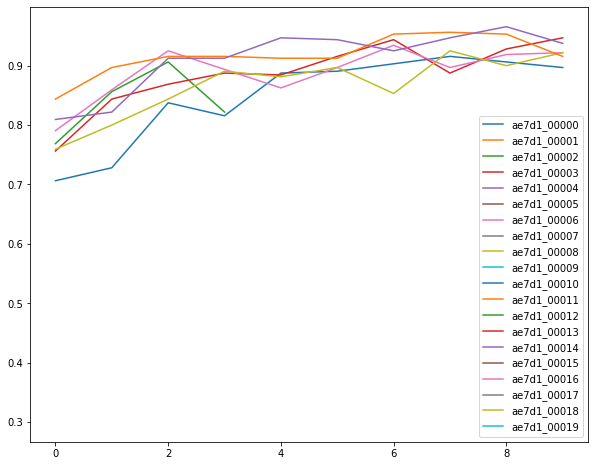

In [44]:
plot_results(analysis, figsize=(10,8))

You see that the majority of the trials were abandoned, with only a handful considered promising enough to continue training. Let's look at the best performing configuration. Use the *get_best_config* method on *analysis* to see this information. Does this match the result in the final experiments table above?

In [45]:
analysis.get_best_config("mean_accuracy", "max")

{'lr': 0.08597002583521468, 'momentum': 0.5}

## HyperOpt

So far we've looked at how Ray Tune can use various scheduling strategies to optimise the hyperparameter search. The flexibility of Tune, however, doesn't end there. It also allows us to plug external frameworks to perform the **selection** of hyperparameters for the individual experiments. As HyperOpt is one of the external frameworks supported by Tune, we could use some Bayesian reasoning in exploring the space. In this way we can incorporate previous knowledge in the process and also actively explore more promising regions of space.

In addition, Ray Tune also supports the following other search algorithms:

* [Ax](https://ax.dev/)
* [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization)
* [HpBandSter](https://github.com/automl/HpBandSter)
* [FAML](https://github.com/microsoft/FLAML)
* [scikit-optimize](https://scikit-optimize.github.io/stable/)
* ...
* and many more

Let's see the HyperOpt/Ray Tune integration in action. First we need some extra libraries (HyperOpt included).

In [46]:
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch

Define the search space (note that we are using *hp.* functions for the hyperparameter sampling).

In [47]:
space = {
    "lr": hp.uniform("learning_rate", 0.0001, 0.1),
    "momentum": hp.uniform("momentum", 0.1, 0.9)
}

Now let's wrap hyperopt in the HyperOptSearch object provided by tune. The arguments are pretty self-explanatory.

In [48]:
hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max", random_state_seed=1234)

The only argument we need to provide this time is the training loop and *search_alg*. There is no need to specify the search space as this has already been provided to the *HyperOptSerach* object and is handled externally. 

Now set the search algorithm in the *tune.run* call and run the search.

**Optional**: If you are feeling adventurous switch to the ASHA scheduler and increase the number of experiments to 20. Do you observe a difference in the behaviour of Ray Tune when scheduling experiments? How does it differ from the previous ASHA run? Why does it behave this way?

In [49]:
analysis = tune.run(
    run_or_experiment = train_mnist, 
    search_alg = hyperopt_search,
    num_samples = 20,
    scheduler=asha
)

(run pid=206) 2023-05-09 12:00:52,683	INFO trial_runner.py:803 -- starting train_mnist_d1412873


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:00:55 (running for 00:00:03.40)
(run pid=206) Memory usage on this node: 2.8/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=0
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
(run pid=206) Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_12-00-51
(run pid=206) Number of trials: 1/20 (1 RUNNING)
(run pid=206) +----------------------+----------+------------------+-----------+------------+
(run pid=206) | Trial name           | status   | loc              |        lr |   momentum |
(run pid=206) |----------------------+----------+------------------+-----------+------------|
(run pid=206) | train_mnist_d1412873 | RUNNING  | 10.0.68.175:5751 | 0.0348662 |   0.804396 |
(run pid=206) +----------------------+----------+------------------+-----------+------------+

(run pid=206) 2023-05-09 12:00:56,049	INFO trial_runner.py:803 -- starting train_mnist_d3484c14


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:00:58 (running for 00:00:06.70)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=0
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.875 | Iter 1.000: 0.7875
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_12-00-51
(run pid=206) Number of trials: 3/20 (1 PENDING, 2 RUNNING)
(run pid=206) +----------------------+----------+------------------+-----------+------------+----------+--------+------------------+
(run pid=206) | Trial name           | status   | loc              |        lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |----------------------+----------+------------------+-----------+------------+----------+--------+------------------|
(run pid=206) | train_mnist_d1412873 | RUNNING  | 10.0.6

(run pid=206) 2023-05-09 12:01:00,140	INFO trial_runner.py:803 -- starting train_mnist_d3e2ecbd
(run pid=206) 2023-05-09 12:01:01,154	INFO trial_runner.py:803 -- starting train_mnist_d652d45b


(run pid=206) Result for train_mnist_d3e2ecbd:
(run pid=206)   date: 2023-05-09_12-01-02
(run pid=206)   done: true
(run pid=206)   experiment_id: ebf9b801d4a74ca5afebe17728c6598d
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.696875
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 5853
(run pid=206)   time_since_restore: 0.378983736038208
(run pid=206)   time_this_iter_s: 0.378983736038208
(run pid=206)   time_total_s: 0.378983736038208
(run pid=206)   timestamp: 1683658862
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: d3e2ecbd
(run pid=206)   warmup_time: 0.0021610260009765625
(run pid=206)   
(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:01:03 (running for 00:00:11.77)
(run pid=206) Memory usage on this node: 2.7/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=2
(run pid=206) Bracket: Ite

(run pid=206) 2023-05-09 12:01:05,135	INFO trial_runner.py:803 -- starting train_mnist_d6ed882b
(run pid=206) 2023-05-09 12:01:06,158	INFO trial_runner.py:803 -- starting train_mnist_d94d1463


(run pid=206) Result for train_mnist_d6ed882b:
(run pid=206)   date: 2023-05-09_12-01-07
(run pid=206)   done: true
(run pid=206)   experiment_id: 63263f96ec064f5a87dbcb6876574bd4
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.115625
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 5944
(run pid=206)   time_since_restore: 0.38254427909851074
(run pid=206)   time_this_iter_s: 0.38254427909851074
(run pid=206)   time_total_s: 0.38254427909851074
(run pid=206)   timestamp: 1683658867
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: d6ed882b
(run pid=206)   warmup_time: 0.002150297164916992
(run pid=206)   
(run pid=206) Result for train_mnist_d94d1463:
(run pid=206)   date: 2023-05-09_12-01-08
(run pid=206)   done: false
(run pid=206)   experiment_id: 270d52fc3c9e477fb5c1f7c8e2dd74c0
(run pid=206)   hostname: ray-645a96d59354900

(run pid=206) 2023-05-09 12:01:09,153	INFO trial_runner.py:803 -- starting train_mnist_d9e913cf


(run pid=206) Result for train_mnist_d94d1463:
(run pid=206)   date: 2023-05-09_12-01-11
(run pid=206)   done: true
(run pid=206)   experiment_id: 270d52fc3c9e477fb5c1f7c8e2dd74c0
(run pid=206)   experiment_tag: 6_lr=0.039986,momentum=0.87948
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-worker-0
(run pid=206)   iterations_since_restore: 10
(run pid=206)   mean_accuracy: 0.94375
(run pid=206)   node_ip: 10.0.73.213
(run pid=206)   pid: 2405
(run pid=206)   time_since_restore: 3.2844996452331543
(run pid=206)   time_this_iter_s: 0.3505737781524658
(run pid=206)   time_total_s: 3.2844996452331543
(run pid=206)   timestamp: 1683658871
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 10
(run pid=206)   trial_id: d94d1463
(run pid=206)   warmup_time: 0.0027964115142822266
(run pid=206)   
(run pid=206) Result for train_mnist_d9e913cf:
(run pid=206)   date: 2023-05-09_12-01-11
(run pid=206)   done: true
(run pid=206)   experiment_id: 1d81c05a55f14d1

(run pid=206) 2023-05-09 12:01:13,173	INFO trial_runner.py:803 -- starting train_mnist_dbb21f04
(run pid=206) 2023-05-09 12:01:14,157	INFO trial_runner.py:803 -- starting train_mnist_de1ace37


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:01:16 (running for 00:00:24.80)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=5
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8796875 | Iter 1.000: 0.7578125
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_12-00-51
(run pid=206) Number of trials: 9/20 (2 RUNNING, 7 TERMINATED)
(run pid=206) +----------------------+------------+------------------+------------+------------+----------+--------+------------------+
(run pid=206) | Trial name           | status     | loc              |         lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |----------------------+------------+------------------+------------+------------+----------+--------+------------------|
(run pid=206) | train_mnist_dbb21f04 

(run pid=206) 2023-05-09 12:01:18,158	INFO trial_runner.py:803 -- starting train_mnist_e00a4de2
(run pid=206) 2023-05-09 12:01:19,117	INFO trial_runner.py:803 -- starting train_mnist_e1102381


(run pid=206) Result for train_mnist_e00a4de2:
(run pid=206)   date: 2023-05-09_12-01-20
(run pid=206)   done: false
(run pid=206)   experiment_id: a5bad175316b4b1e930d5b4a82cb7b80
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-worker-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.796875
(run pid=206)   node_ip: 10.0.73.213
(run pid=206)   pid: 2517
(run pid=206)   time_since_restore: 0.382016658782959
(run pid=206)   time_this_iter_s: 0.382016658782959
(run pid=206)   time_total_s: 0.382016658782959
(run pid=206)   timestamp: 1683658880
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: e00a4de2
(run pid=206)   warmup_time: 0.0026493072509765625
(run pid=206)   
(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:01:21 (running for 00:00:29.82)
(run pid=206) Memory usage on this node: 2.8/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=7
(run pid=206) Bracket: 

(run pid=206) 2023-05-09 12:01:23,146	INFO trial_runner.py:803 -- starting train_mnist_e1a29cfd
(run pid=206) 2023-05-09 12:01:24,156	INFO trial_runner.py:803 -- starting train_mnist_e409556f


(run pid=206) Result for train_mnist_e1a29cfd:
(run pid=206)   date: 2023-05-09_12-01-25
(run pid=206)   done: true
(run pid=206)   experiment_id: da835c1190824b4d9b4c68b904212653
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.66875
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 6355
(run pid=206)   time_since_restore: 0.375521183013916
(run pid=206)   time_this_iter_s: 0.375521183013916
(run pid=206)   time_total_s: 0.375521183013916
(run pid=206)   timestamp: 1683658885
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: e1a29cfd
(run pid=206)   warmup_time: 0.0020666122436523438
(run pid=206)   
(run pid=206) Result for train_mnist_e409556f:
(run pid=206)   date: 2023-05-09_12-01-26
(run pid=206)   done: true
(run pid=206)   experiment_id: 1afe5c68fe3b4501b92505049edd2b01
(run pid=206)   hostname: ray-645a96d5935490051989b8

(run pid=206) 2023-05-09 12:01:27,120	INFO trial_runner.py:803 -- starting train_mnist_e4a4a626
(run pid=206) 2023-05-09 12:01:28,077	INFO trial_runner.py:803 -- starting train_mnist_e667b26a


(run pid=206) Result for train_mnist_e4a4a626:
(run pid=206)   date: 2023-05-09_12-01-29
(run pid=206)   done: true
(run pid=206)   experiment_id: 334d1902d19e41dfba769d663df35084
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-head-0
(run pid=206)   iterations_since_restore: 1
(run pid=206)   mean_accuracy: 0.484375
(run pid=206)   node_ip: 10.0.68.175
(run pid=206)   pid: 6460
(run pid=206)   time_since_restore: 0.37890625
(run pid=206)   time_this_iter_s: 0.37890625
(run pid=206)   time_total_s: 0.37890625
(run pid=206)   timestamp: 1683658889
(run pid=206)   timesteps_since_restore: 0
(run pid=206)   training_iteration: 1
(run pid=206)   trial_id: e4a4a626
(run pid=206)   warmup_time: 0.002177715301513672
(run pid=206)   
(run pid=206) Result for train_mnist_e667b26a:
(run pid=206)   date: 2023-05-09_12-01-30
(run pid=206)   done: true
(run pid=206)   experiment_id: ff1339e0447440d19b7ee06d3eeb1ba1
(run pid=206)   hostname: ray-645a96d5935490051989b8cf-ray-worker-0
(run 

(run pid=206) 2023-05-09 12:01:31,119	INFO trial_runner.py:803 -- starting train_mnist_e6fbd4be
(run pid=206) 2023-05-09 12:01:32,057	INFO trial_runner.py:803 -- starting train_mnist_e8c9d81a


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:01:34 (running for 00:00:42.68)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=13
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.878125 | Iter 1.000: 0.75
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_12-00-51
(run pid=206) Number of trials: 17/20 (2 RUNNING, 15 TERMINATED)
(run pid=206) +----------------------+------------+------------------+------------+------------+----------+--------+------------------+
(run pid=206) | Trial name           | status     | loc              |         lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |----------------------+------------+------------------+------------+------------+----------+--------+------------------|
(run pid=206) | train_mnist_e6fbd4be | R

(run pid=206) 2023-05-09 12:01:36,138	INFO trial_runner.py:803 -- starting train_mnist_eab25296
(run pid=206) 2023-05-09 12:01:37,145	INFO trial_runner.py:803 -- starting train_mnist_ebc7b172


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:01:39 (running for 00:00:47.87)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=15
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.878125 | Iter 1.000: 0.74375
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_12-00-51
(run pid=206) Number of trials: 19/20 (2 RUNNING, 17 TERMINATED)
(run pid=206) +----------------------+------------+------------------+------------+------------+----------+--------+------------------+
(run pid=206) | Trial name           | status     | loc              |         lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |----------------------+------------+------------------+------------+------------+----------+--------+------------------|
(run pid=206) | train_mnist_eab25296 

(run pid=206) 2023-05-09 12:01:41,172	INFO trial_runner.py:803 -- starting train_mnist_edcad423


(run pid=206) == Status ==
(run pid=206) Current time: 2023-05-09 12:01:43 (running for 00:00:51.82)
(run pid=206) Memory usage on this node: 2.9/30.6 GiB
(run pid=206) Using AsyncHyperBand: num_stopped=16
(run pid=206) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8890625 | Iter 1.000: 0.7453125
(run pid=206) Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/5.0 GiB heap, 0.0/2.3 GiB objects
(run pid=206) Result logdir: /home/ray/ray_results/train_mnist_2023-05-09_12-00-51
(run pid=206) Number of trials: 20/20 (2 RUNNING, 18 TERMINATED)
(run pid=206) +----------------------+------------+------------------+------------+------------+----------+--------+------------------+
(run pid=206) | Trial name           | status     | loc              |         lr |   momentum |      acc |   iter |   total time (s) |
(run pid=206) |----------------------+------------+------------------+------------+------------+----------+--------+------------------|
(run pid=206) | train_mnist_eab252

(run pid=206) 2023-05-09 12:01:43,977	INFO tune.py:701 -- Total run time: 52.35 seconds (52.22 seconds for the tuning loop).


Now let's see the accuracy results.

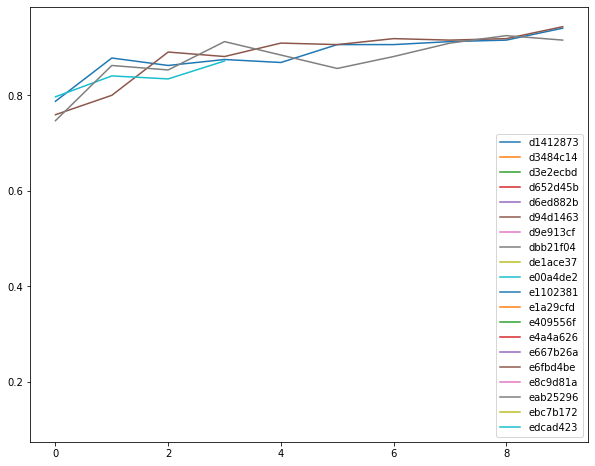

In [50]:
plot_results(analysis, figsize=(10,8))